=========  ===============================================<br>

    run                 task<br>
=========  ===============================================<br>
    1          Baseline, eyes open<br>
    2          Baseline, eyes closed<br>
3, 7, 11       Motor execution: left vs right hand<br>
4, 8, 12       Motor imagery: left vs right hand<br>
5, 9, 13       Motor execution: hands vs feet<br>
6, 10, 14      Motor imagery: hands vs feet<br>
=========  ===============================================<br>

In [0]:
!pip install mne

     |████████████████████████████████| 6.3MB 2.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/71/40/30/fb9a9bdeac02c6b3b144be66ac345c5b5587a7d7610564535b
Successfully built mne


# ResNet Keras

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout, Add
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2, l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf


def identity_block(X, f, filters, stage, block, l1=0.0, l2=0.01):
    
    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), data_format='channels_first',
               padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0),
              activity_regularizer=l1_l2(l1, l2))(X)
    X = BatchNormalization(axis = 1, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), data_format='channels_first', padding = 'same',
               name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0),
              activity_regularizer=l1_l2(l1, l2))(X)
    X = BatchNormalization(axis = 1, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), data_format='channels_first', padding = 'valid',
               name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0),
              activity_regularizer=l1_l2(l1, l2))(X)
    X = BatchNormalization(axis = 1, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X
  
def convolutional_block(X, f, filters, stage, block, s=2, l1=0.0, l2=0.01):

    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s),
               data_format='channels_first', padding='same',
               name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0),
              activity_regularizer=l1_l2(l1, l2))(X)
    X = BatchNormalization(axis=1, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1),
               data_format='channels_first', padding='same', name=conv_name_base + '2b',
               kernel_initializer=glorot_uniform(seed=0),
              activity_regularizer=l1_l2(l1, l2))(X)
    X = BatchNormalization(axis=1, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1),
               data_format='channels_first', padding='same', name=conv_name_base + '2c',
               kernel_initializer=glorot_uniform(seed=0),
              activity_regularizer=l1_l2(l1, l2))(X)
    X = BatchNormalization(axis=1, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), data_format='channels_first', 
                        padding='same', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0),
              activity_regularizer=l1_l2(l1, l2))(X_shortcut)
    X_shortcut = BatchNormalization(axis=1, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def ResNet(chans=64, samples=121, l1=0.0, l2=0.01):
  input_shape= (1, chans, samples)
  input1   = Input(shape = input_shape)

  ##################################################################
  X = Conv2D(128, (1, 64), padding = 'same',
                        input_shape = input_shape, data_format='channels_first',
                        kernel_initializer = glorot_uniform(seed=0),
              activity_regularizer=l1_l2(l1, l2))(input1)
  X = BatchNormalization(axis = 1)(X)
  X = DepthwiseConv2D((64, 1), kernel_initializer = glorot_uniform(seed=0), 
                                 depth_multiplier = 2, data_format='channels_first',
              activity_regularizer=l1_l2(l1, l2))(X)
  X = BatchNormalization(axis = 1)(X)
  X = Activation('elu')(X)
  X = AveragePooling2D((1, 2), data_format='channels_first')(X)

  # Stage 2
  X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1, l1=l1, l2=l2)
  X = identity_block(X, 3, [64, 64, 256], stage=2, block='b', l1=l1, l2=l2)
  X = identity_block(X, 3, [64, 64, 256], stage=2, block='c', l1=l1, l2=l2)

  ### START CODE HERE ###

  # Stage 3 (≈4 lines)
  X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=1, l1=l1, l2=l2)
  X = identity_block(X, 3, [128, 128, 512], stage=3, block='b', l1=l1, l2=l2)
  X = identity_block(X, 3, [128, 128, 512], stage=3, block='c', l1=l1, l2=l2)
  X = identity_block(X, 3, [128, 128, 512], stage=3, block='d', l1=l1, l2=l2)

  # Stage 4 (≈6 lines)
#   X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=1, l1=l1, l2=l2)
#   X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b', l1=l1, l2=l2)
#   X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c', l1=l1, l2=l2)
#   X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d', l1=l1, l2=l2)
#   X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e', l1=l1, l2=l2)
#   X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f', l1=l1, l2=l2)
  
#   # Stage 5 (≈4 lines)
#   X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2, l1=l1, l2=l2)
#   X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
#   X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
#   X = identity_block(X, 3, [512, 512, 2048], stage=5, block='d')

#   # Stage 6 (≈4 lines)
#   X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=6, block='a', s=2, l1=l1, l2=l2)
#   X = identity_block(X, 3, [512, 512, 2048], stage=6, block='b')
#   X = identity_block(X, 3, [512, 512, 2048], stage=6, block='c')
#   X = identity_block(X, 3, [512, 512, 2048], stage=6, block='d')


  # Stage 7 (≈3 lines)
#   X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=7, block='a', s=2, l1=l1, l2=l2)
#   X = identity_block(X, 3, [512, 512, 2048], stage=7, block='b', l1=l1, l2=l2)
#   X = identity_block(X, 3, [512, 512, 2048], stage=7, block='c', l1=l1, l2=l2)

  # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
  X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

  ### END CODE HERE ###

  # output layer
  X = Flatten()(X)
  X = Dense(64, activation='relu')(X)
  X = Dense(32, activation='relu')(X)
  X = Dense(1, activation='sigmoid', name='fc1', kernel_initializer = glorot_uniform(seed=0))(X)


  # Create model
  model = Model(inputs = input1, outputs = X, name='ResNet50')

  return model


# EGGNet Keras Model

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout', gpu=True):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.
    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 
    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (1, Chans, Samples))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (1, Chans, Samples),
                                   use_bias = False)(input1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization(axis = 1)(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
#     dense        = Dense(50,name='dense1', kernel_constraint = max_norm(norm_rate))(flatten)
    dense        = Dense(1, name = 'out', kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('sigmoid', name = 'sigmoid')(dense)
    
    return Model(inputs=input1, outputs=softmax)

 

In [0]:
def DeepConvNet(nb_classes, Chans = 64, Samples = 256,
                dropoutRate = 0.5):
    """ Keras implementation of the Deep Convolutional Network as described in
    Schirrmeister et. al. (2017), Human Brain Mapping.
    
    This implementation assumes the input is a 2-second EEG signal sampled at 
    128Hz, as opposed to signals sampled at 250Hz as described in the original
    paper. We also perform temporal convolutions of length (1, 5) as opposed
    to (1, 10) due to this sampling rate difference. 
    
    Note that we use the max_norm constraint on all convolutional layers, as 
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication 
    with the original authors.
    
                      ours        original paper
    pool_size        1, 2        1, 3
    strides          1, 2        1, 3
    conv filters     1, 5        1, 10
    
    Note that this implementation has not been verified by the original 
    authors. 
    
    """
#     K.set_image_data_format('channels_first')
    # start the model
    input_main   = Input((1, Chans, Samples))
    block1       = Conv2D(25, (1, 11), 
                                 input_shape=(1, Chans, Samples),data_format='channels_first',
                                 kernel_constraint = max_norm(2.1, axis=(0,1,2)))(input_main)
    block1       = Conv2D(25, (Chans, 1),data_format='channels_first',
                                 kernel_constraint = max_norm(2.1, axis=(0,1,2)))(block1)
    block1       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block1)
    block1       = Activation('elu')(block1)
    block1       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2),data_format='channels_first')(block1)
    block1       = Dropout(dropoutRate)(block1)
  
    block2       = Conv2D(50, (1, 9),data_format='channels_first',
                                 kernel_constraint = max_norm(2.1, axis=(0,1,2)))(block1)
    block2       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2),data_format='channels_first')(block2)
    block2       = Dropout(dropoutRate)(block2)
    
    block3       = Conv2D(100, (1, 7),data_format='channels_first',
                                 kernel_constraint = max_norm(2.1, axis=(0,1,2)))(block2)
    block3       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block3)
    block3       = Activation('elu')(block3)
    block3       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2),data_format='channels_first')(block3)
    block3       = Dropout(dropoutRate)(block3)
    
    block4       = Conv2D(200, (1, 5),data_format='channels_first',
                                 kernel_constraint = max_norm(2.1, axis=(0,1,2)))(block3)
    block4       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block4)
    block4       = Activation('elu')(block4)
#     block4       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2),data_format='channels_first')(block4)
    block4       = Dropout(dropoutRate)(block4)
    
    
    block5       = Conv2D(250, (1, 3),data_format='channels_first',
                                 kernel_constraint = max_norm(2.1, axis=(0,1,2)))(block4)
    block5       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block5)
    block5       = Activation('elu')(block5)
#     block5       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2),data_format='channels_first')(block5)
    block5       = Dropout(dropoutRate)(block5)
  
  
#     block6       = Conv2D(250, (1, 2),data_format='channels_first',
#                                  kernel_constraint = max_norm(2., axis=(0,1,2)))(block5)
#     block6       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block6)
#     block6       = Activation('elu')(block6)
# #     block5       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2),data_format='channels_first')(block5)
#     block6       = Dropout(dropoutRate)(block6)
    
    flatten      = Flatten()(block5)
    
    dense        = Dense(32, kernel_constraint = max_norm(0.6), activation='relu')(flatten)
    dense        = Dense(1, kernel_constraint = max_norm(0.6))(dense)
    softmax      = Activation('sigmoid')(dense)
    
    return Model(inputs=input_main, outputs=softmax)
  
# DeepConvNet(2, Chans = 64, Samples = 113,
#                 dropoutRate = 0.5).summary()

# EFFNet

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.callbacks import *


def get_post(x_in):
    x = LeakyReLU()(x_in)
    x = BatchNormalization()(x)
    return x

def get_block(x_in, ch_in, ch_out):
    x = Conv2D(ch_in,
               kernel_size=(1, 1),
               padding='same',
               use_bias=False, data_format='channels_first')(x_in)
    x = get_post(x)

    x = DepthwiseConv2D(kernel_size=(1, 3), padding='same', use_bias=False, data_format='channels_first')(x)
    x = get_post(x)
    x = MaxPool2D(pool_size=(2, 1),
                  strides=(2, 1), data_format='channels_first')(x) # Separable pooling

    x = DepthwiseConv2D(kernel_size=(3, 1),
                        padding='same',
                        use_bias=False, data_format='channels_first')(x)
    x = get_post(x)

    x = Conv2D(ch_out,
               kernel_size=(2, 1),
               strides=(1, 2),
               padding='same',
               use_bias=False, data_format='channels_first')(x)
    x = get_post(x)

    return x


def Effnet(input_shape, nb_classes, include_top=True, weights=None):
    x_in = Input(shape=input_shape)

    x = get_block(x_in, 32, 64)
    x = get_block(x, 64, 128)
    x = get_block(x, 128, 256)

    if include_top:
        x = Flatten()(x)
        x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=x_in, outputs=x)

    if weights is not None:
        model.load_weights(weights, by_name=True)

    return model

# My Models

In [0]:

def my_net(nb_classes=2, Chans = 64, Samples = 321, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout', gpu=True):
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (1, Chans, Samples))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (1, Chans, Samples),
                                   use_bias = False, data_format='channels_first')(input1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.), data_format='channels_first')(block1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 2), data_format='channels_first')(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same', data_format='channels_first')(block1)
    block2       = BatchNormalization(axis = 1)(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 4), data_format='channels_first')(block2)
    block2       = dropoutType(dropoutRate)(block2)
    
    block3       = Conv2D(F2, (1, 8), padding='same', data_format='channels_first')(block2)
    block3       = BatchNormalization(axis=1)(block3)
    block3       = Activation('elu')(block3)
    block3       = AveragePooling2D((1, 8), data_format='channels_first')(block3)
        
    flatten      = Flatten(name = 'flatten')(block3)
    
#     dense        = Dense(50,name='dense1', kernel_constraint = max_norm(norm_rate))(flatten)
    dense        = Dense(1, name = 'out', kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('sigmoid', name = 'sigmoid')(dense)
    
    return Model(inputs=input1, outputs=softmax)

In [0]:
def CNN_model(dropout=0.4, l1=0.0, l2=0.01, chans=64, samples=113):
  
  model = Sequential()
  
#   Layer 1
  model.add(Conv2D(256, (2, chans), input_shape=(1, chans, samples), activity_regularizer=l1_l2(l1, l2), name='conv1',
                   padding='same', data_format='channels_first'))
  model.add(BatchNormalization(axis=1))
  model.add(DepthwiseConv2D((chans, 4), depth_multiplier = 3, activity_regularizer=l1_l2(l1, l2),
                            data_format='channels_first'))
  model.add(BatchNormalization(axis=1))
  model.add(Activation('elu'))
  model.add(AveragePooling2D((1, 2), data_format='channels_first', name='pool1'))
  model.add(Dropout(dropout))
            
#   Layer 2  
  model.add(Conv2D(256, (1, 1), padding='same', name='conv2', activity_regularizer=l1_l2(l1, l2), data_format='channels_first'))
  model.add(BatchNormalization(axis=1))
  model.add(Conv2D(256, (3, 3), padding='same', name='conv3', activity_regularizer=l1_l2(l1, l2),  data_format='channels_first',
                   activation='elu'))
  model.add(BatchNormalization(axis=1))
  model.add(Activation('elu'))
  model.add(MaxPooling2D((1, 2), data_format='channels_first', name='pool2',))
  model.add(Dropout(dropout))
  
#   Layer 3
  model.add(Conv2D(256, (5, 5), padding='same', name='conv4', activity_regularizer=l1_l2(l1, l2), data_format='channels_first'))
  model.add(BatchNormalization(axis=1))
  model.add(Activation('elu'))
  
#   Layer 4
  model.add(Conv2D(512, (5, 5), padding='same', name='conv5', activity_regularizer=l1_l2(l1, l2),  data_format='channels_first'))
  model.add(BatchNormalization(axis=1))
  model.add(Activation('elu'))
  model.add(MaxPooling2D((1, 2), data_format='channels_first', name='pool3',))
  model.add(Dropout(dropout))
  
#   Layer 5
  model.add(Conv2D(512, (7, 7), padding='same', name='conv6', activity_regularizer=l1_l2(l1, l2), data_format='channels_first'))
  model.add(BatchNormalization(axis=1))
  model.add(Activation('elu'))
  
#   Layer 6
  model.add(Conv2D(512, (7, 7), padding='same', name='conv7', activity_regularizer=l1_l2(l1, l2),  data_format='channels_first'))
  model.add(BatchNormalization(axis=1))
  model.add(Activation('elu'))
  model.add(MaxPooling2D((1, 2), data_format='channels_first', name='pool4',))
  model.add(Dropout(dropout))
  
# #   Layer 7
#   model.add(Conv2D(1024, (5, 5), padding='same', name='conv8', activity_regularizer=l1_l2(l1, l2), data_format='channels_first'))
#   model.add(BatchNormalization(axis=1))
#   model.add(Activation('elu'))
  
# #   Layer 8
#   model.add(Conv2D(1024, (3,3), padding='same', name='conv9', activity_regularizer=l1_l2(l1, l2),  data_format='channels_first'))
#   model.add(BatchNormalization(axis=1))
#   model.add(Activation('elu'))
#   model.add(MaxPooling2D((1, 2), data_format='channels_first', name='pool5',))
#   model.add(Dropout(dropout))
            
#   Flatten
  model.add(Flatten())
  
#   Layer 9
  model.add(Dense(16, activation='relu', activity_regularizer=l1_l2(l1, l2)))
  model.add(Dropout(dropout))
  
#   Output Layer
  model.add(Dense(1, activation='sigmoid'))
            
  return model

# Load data and Preprocessing

In [0]:
%load_ext autoreload
%autoreload

import numpy as np
from tensorflow.keras import *
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LassoLarsCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
import mne
import pandas as pd
from matplotlib import pyplot as plt 

from tensorflow.keras.models import load_model

In [0]:
def download_dataset(subjects, runs):
    raws_list = []
    for i in subjects:
        try:
            raws_list.append(eegbci.load_data(i, runs))
        except Exception as e:
            print(i,' => ' ,e)
            
    return raws_list

# Load and Preprocessing functions

In [0]:
def load_dataset(subjects, runs):
  
  # check if dataset is downloaded
  download_dataset(subjects, runs)
  
  raw = None
  
  for i in subjects[1:]:
      for f in eegbci.load_data(i, runs):
          
          if raw is None:
            raw = read_raw_edf(f, preload=True)
          else:
            try:
              raw = concatenate_raws([raw, read_raw_edf(f, preload=True)])
            except:
              print('subject {} failed to concatinate'.format(i))
          
  return raw
  
def preprocess(raw, event_id, use_filter = True, low_freq=7, high_freq=30, tmin=1, tmax=2):
    # strip channel names of "." characters
    raw.rename_channels(lambda x: x.strip('.'))

    # Apply band-pass filter
    if use_filter:
      raw.filter(low_freq, high_freq)


    events, _ = get_events(raw)

    picks = get_picks(raw)

    # Read epochs (train will be done only between 1 and 2s)
    # Testing will be done with a running classifier
    epochs = get_epochs(raw, events, event_id)

    epochs_train = epochs.copy().crop(tmin=tmin, tmax=tmax)
    labels = epochs_train.events[:, -1] - 2

    labels = labels.reshape((labels.shape[0],1))
    epochs_data_train = epochs_train.get_data()
    epochs_data_train = epochs_data_train.reshape((epochs_data_train.shape[0],1, epochs_data_train.shape[1], epochs_data_train.shape[2]))

    return epochs_data_train, labels


def get_events(raw, event_id=dict(T1=2, T2=3)):
    return events_from_annotations(raw, event_id=event_id)

def get_epochs(raw,events, event_id):
  
    return Epochs(raw, events, event_id, -1, 4, proj=True, picks=get_picks(raw),
                  baseline=(None, None), preload=True)
  
  
def get_picks(raw):
    return pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

In [0]:
subjects = [i for i in range(1,86)]
runs = [4, 8, 12] # motor Imaginery: left hand vs right hand

raw = load_dataset(subjects, runs)

runs = [3, 7, 11]  # Motor execution: left hand vs right hand

# # concatinate two raws
raw = concatenate_raws([raw, load_dataset(subjects, runs)])
# raw.get_data().shape

Using default location ~/mne_data for EEGBCI...
Creating ~/mne_data
[........................................] 100.00% (  2.5 MB,  34.5 MB/s) -   
Do you want to set the path:
    /root/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? 
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
[........................................] 100.00% (  2.5 MB,  27.2 MB/s) -   
[........................................] 100.00% (  2.5 MB,  29.3 MB/s) -   
[........................................] 100.00% (  2.4 MB,  31.1 MB/s) \   
[........................................] 100.00% (  2.4 MB,  22.5 MB/s) -   
[........................................] 100.00% (  2.4 MB,  24.8 MB/s) -   
[........................................] 100.00% (  2.5 MB,  30.5 MB/s) -   
[........................................] 100.00% (  2.5 MB,  38.0 MB/s) -   
[........................................] 100.00% (  2.5 MB,  32.6 MB/s) \   
[.....................

In [0]:
# Tune parameters
tmin = -0.2
tmax = 0.5
low_freq = 5
high_freq = 60

event_id = dict(right=2, left=3)
epochs_data_train, labels = preprocess(raw, event_id, use_filter=True, low_freq=low_freq, high_freq=high_freq, tmax=tmax, tmin=tmin)

Filtering raw data in 504 contiguous segments
Setting up band-pass filter from 5 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T1', 'T2']
7560 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 7560 events and 801 original time points ...
433 bad epochs dropped


In [0]:
# epochs = get_epochs(raw, get_events(raw)[0], event_id)
# epochs.plot()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(epochs_data_train, labels, test_size=0.1, random_state=42, shuffle=True)

print('shape of train-set-X: {} \nshape of test-set-X: {}'.format(X_train.shape, X_test.shape))
print('shape of train-set-y: {} \nshape of test-set-y: {}'.format(y_train.shape, y_test.shape))

shape of train-set-X: (6414, 1, 64, 113) 
shape of test-set-X: (713, 1, 64, 113)
shape of train-set-y: (6414, 1) 
shape of test-set-y: (713, 1)


In [0]:
# model = my_net(2, Chans = 64, Samples = X_train.shape[-1],F1=16, D=3, F2=48,
#              dropoutRate = 0.0, kernLength = 96,norm_rate = 0.0, dropoutType = 'Dropout')
# model = EEGNet(2, Samples=X_train.shape[-1], kernLength=96, Chans=64, F1=16, D=3, F2=48, dropoutRate=0.0, norm_rate=0)

# model = CNN_model(samples=X_train.shape[-1], l1=0.0, l2=0.000, dropout=0.4)
# model = ResNet(samples=X_train.shape[-1], l1=0.00, l2=0.0)
# model = Effnet((1, 64, X_train.shape[-1]), 1)
model = DeepConvNet(2, Chans = 64, Samples = X_train.shape[-1], dropoutRate = 0.15)

In [0]:
#load saved model
# model = load_model('model_left_vs_right_hand_113acc_76.h5')

In [34]:
model.summary()
# for layer in model.layers:
#     layer.trainable = True

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 64, 113)]      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 64, 103)       300       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 25, 1, 103)        40025     
_________________________________________________________________
batch_normalization_5 (Batch (None, 25, 1, 103)        100       
_________________________________________________________________
activation_6 (Activation)    (None, 25, 1, 103)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 1, 51)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 25, 1, 51)         0   

In [0]:
optimizer = optimizers.Adam(lr=0.001, decay=1e-5)
model.compile(optimizer , loss=losses.binary_crossentropy , metrics=['acc'])

In [36]:
batch_size = 256
# callback = EarlyStopping('val_loss', patience=300, mode='min', restore_best_weights=True)
earlyStopping = EarlyStopping(monitor='val_loss', patience=40, verbose=0, mode='min')
mcp_save = ModelCheckpoint('mdl_wts.hdf5',verbose=1, save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.0001, patience=25, verbose=1, epsilon=1e-4, mode='min')

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=1500, validation_data=(X_test, y_test),
                   callbacks=[ mcp_save, reduce_lr_loss])

W0724 19:28:00.956040 140187433715584 callbacks.py:1791] `epsilon` argument is deprecated and will be removed, use `min_delta` instead.


Train on 6414 samples, validate on 713 samples
Epoch 1/1500
6400/6414 [============================>.] - ETA: 0s - loss: 0.7029 - acc: 0.5041
Epoch 00001: val_loss improved from inf to 0.69337, saving model to mdl_wts.hdf5
6414/6414 [==============================] - 6s 895us/sample - loss: 0.7028 - acc: 0.5045 - val_loss: 0.6934 - val_acc: 0.4993
Epoch 2/1500
6400/6414 [============================>.] - ETA: 0s - loss: 0.6898 - acc: 0.5398
Epoch 00002: val_loss did not improve from 0.69337
6414/6414 [==============================] - 2s 247us/sample - loss: 0.6898 - acc: 0.5396 - val_loss: 0.6936 - val_acc: 0.4965
Epoch 3/1500
6400/6414 [============================>.] - ETA: 0s - loss: 0.6692 - acc: 0.5820
Epoch 00003: val_loss did not improve from 0.69337
6414/6414 [==============================] - 2s 241us/sample - loss: 0.6691 - acc: 0.5820 - val_loss: 0.6951 - val_acc: 0.4979
Epoch 4/1500
6400/6414 [============================>.] - ETA: 0s - loss: 0.6487 - acc: 0.6120
Epoch 000

In [0]:
best_model = load_model('mdl_wts.hdf5')

In [27]:
model.evaluate(X_test, y_test)
best_model.evaluate(X_test, y_test)

713/713 [==============================] - 0s 488us/sample - loss: 0.4297 - acc: 0.7742


[0.4296958145971552, 0.7741935]

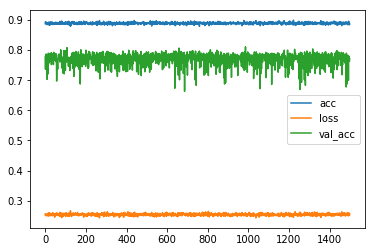

In [29]:
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_acc'])
plt.legend(['acc','loss','val_acc'])

In [0]:
subjects = [i for i in range(86,110)]
# [3, 7, 11]
test_epochs, test_labels = preprocess(load_dataset(subjects, [4, 8, 12]), event_id, use_filter=True,low_freq=low_freq,
                                      high_freq=high_freq, tmax=tmax, tmin=tmin)

In [28]:
loss, accuracy = model.evaluate(test_epochs, test_labels)
loss, accuracy = best_model.evaluate(test_epochs, test_labels)

830/830 [==============================] - 0s 230us/sample - loss: 0.4613 - acc: 0.7928


In [0]:
best_model.save('model_left_vs_right_hand_' + str(X_train.shape[-1]) + 'acc_' + str(accuracy) + '.h5')

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a text file.
uploaded = drive.CreateFile({'title': 'Sample file.txt'})
uploaded.SetContentString('Sample upload file content')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [0]:
from tensorflow.keras.models import load_model
# from keras.initializers import glorot_uniform
loaded_model = load_model('model_321.h5')

W0716 20:25:49.529568 139731607201664 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0716 20:25:49.531297 139731607201664 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0716 20:25:49.534968 139731607201664 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecat

In [0]:
# loaded_model.summary()

In [0]:
loaded_model.evaluate(X_train, y_train)

2822/2822 [==============================] - 1s 523us/sample - loss: 0.7838 - acc: 0.4848


[0.7838151460417107, 0.48476258]

In [0]:
loaded_model.evaluate(X_test, y_test)

706/706 [==============================] - 1s 1ms/sample - loss: 0.7754 - acc: 0.5028


[0.7753595951258629, 0.5028329]

In [0]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png', show_shapes=True)

In [0]:
for layer in model.layers:
  if type(layer) is Conv2D:
    print('CONV2D: filters: {}, kernel_size: {}, padding: {}, strides: {}'.format(layer.filters, layer.kernel_size, layer.padding, layer.strides))
  elif type(layer) is SeparableConv2D:
    print('SepConv2D: filters: {}, kernel_size: {}, padding: {}, strides: {}'.format(layer.filters, layer.kernel_size, layer.padding, layer.strides))
  elif type(layer) is AveragePooling2D:
    print('AP2D: pool_size: {}, padding: {}, strides: {}'.format(layer.pool_size,layer.padding, layer.strides))
  elif type(layer) is Dropout:
#     print(layer.rate)
    pass
  else:
    pass
#     print(layer)

CONV2D: filters: 16, kernel_size: (1, 96), padding: same, strides: (1, 1)
AP2D: pool_size: (1, 4), padding: valid, strides: (1, 4)
SepConv2D: filters: 48, kernel_size: (1, 16), padding: same, strides: (1, 1)
AP2D: pool_size: (1, 8), padding: valid, strides: (1, 8)
SepConv2D: filters: 48, kernel_size: (1, 16), padding: same, strides: (1, 1)
AP2D: pool_size: (1, 8), padding: valid, strides: (1, 8)
SepConv2D: filters: 48, kernel_size: (1, 16), padding: same, strides: (1, 1)
AP2D: pool_size: (1, 8), padding: valid, strides: (1, 8)
SepConv2D: filters: 48, kernel_size: (1, 16), padding: same, strides: (1, 1)
AP2D: pool_size: (1, 8), padding: valid, strides: (1, 8)


In [0]:
K.eval(loaded_model.optimizer.lr)

1e-04

In [0]:
K.eval(loaded_model.optimizer.decay)

1e-05

In [0]:
K.eval(loaded_model.non_trainable_variables)

[<tf.Variable 'batch_normalization_111/moving_mean:0' shape=(16,) dtype=float32>,
 <tf.Variable 'batch_normalization_111/moving_variance:0' shape=(16,) dtype=float32>,
 <tf.Variable 'batch_normalization_1_3/moving_mean:0' shape=(48,) dtype=float32>,
 <tf.Variable 'batch_normalization_1_3/moving_variance:0' shape=(48,) dtype=float32>,
 <tf.Variable 'batch_normalization_2_3/moving_mean:0' shape=(48,) dtype=float32>,
 <tf.Variable 'batch_normalization_2_3/moving_variance:0' shape=(48,) dtype=float32>,
 <tf.Variable 'batch_normalization_3_3/moving_mean:0' shape=(48,) dtype=float32>,
 <tf.Variable 'batch_normalization_3_3/moving_variance:0' shape=(48,) dtype=float32>,
 <tf.Variable 'batch_normalization_4_3/moving_mean:0' shape=(48,) dtype=float32>,
 <tf.Variable 'batch_normalization_4_3/moving_variance:0' shape=(48,) dtype=float32>,
 <tf.Variable 'batch_normalization_5_3/moving_mean:0' shape=(48,) dtype=float32>,
 <tf.Variable 'batch_normalization_5_3/moving_variance:0' shape=(48,) dtype=fl

In [0]:
model.weights

[<tf.Variable 'conv2d_31_1/kernel:0' shape=(1, 96, 1, 16) dtype=float32>,
 <tf.Variable 'batch_normalization_111_1/gamma:0' shape=(16,) dtype=float32>,
 <tf.Variable 'batch_normalization_111_1/beta:0' shape=(16,) dtype=float32>,
 <tf.Variable 'batch_normalization_111_1/moving_mean:0' shape=(16,) dtype=float32>,
 <tf.Variable 'batch_normalization_111_1/moving_variance:0' shape=(16,) dtype=float32>,
 <tf.Variable 'depthwise_conv2d_17_1/depthwise_kernel:0' shape=(64, 1, 16, 3) dtype=float32>,
 <tf.Variable 'batch_normalization_112/gamma:0' shape=(48,) dtype=float32>,
 <tf.Variable 'batch_normalization_112/beta:0' shape=(48,) dtype=float32>,
 <tf.Variable 'batch_normalization_112/moving_mean:0' shape=(48,) dtype=float32>,
 <tf.Variable 'batch_normalization_112/moving_variance:0' shape=(48,) dtype=float32>,
 <tf.Variable 'separable_conv2d_63_1/depthwise_kernel:0' shape=(1, 16, 80, 1) dtype=float32>,
 <tf.Variable 'separable_conv2d_63_1/pointwise_kernel:0' shape=(1, 1, 80, 48) dtype=float32>

In [0]:
loaded_model.weights

[<tf.Variable 'conv2d_31/kernel:0' shape=(1, 96, 1, 16) dtype=float32>,
 <tf.Variable 'batch_normalization_111/gamma:0' shape=(16,) dtype=float32>,
 <tf.Variable 'batch_normalization_111/beta:0' shape=(16,) dtype=float32>,
 <tf.Variable 'batch_normalization_111/moving_mean:0' shape=(16,) dtype=float32>,
 <tf.Variable 'batch_normalization_111/moving_variance:0' shape=(16,) dtype=float32>,
 <tf.Variable 'depthwise_conv2d_17/depthwise_kernel:0' shape=(64, 1, 16, 3) dtype=float32>,
 <tf.Variable 'batch_normalization_1_3/gamma:0' shape=(48,) dtype=float32>,
 <tf.Variable 'batch_normalization_1_3/beta:0' shape=(48,) dtype=float32>,
 <tf.Variable 'batch_normalization_1_3/moving_mean:0' shape=(48,) dtype=float32>,
 <tf.Variable 'batch_normalization_1_3/moving_variance:0' shape=(48,) dtype=float32>,
 <tf.Variable 'separable_conv2d_63/depthwise_kernel:0' shape=(1, 16, 80, 1) dtype=float32>,
 <tf.Variable 'separable_conv2d_63/pointwise_kernel:0' shape=(1, 1, 80, 48) dtype=float32>,
 <tf.Variable 